# AUTHORS:


### Abhimanyu Borthakur (406530322)


### Lorenzo Bolls (505997448)


### Arthur Baghdasian (006001418)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from surprise import Reader, Dataset, accuracy
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

## Here is some ad-hoc code to find the number of unique genres for future reference. It's 19 if we ignore "(no genres listed)"

In [2]:
df = pd.read_csv('../data/Synthetic_Movie_Lens/movies.csv')
genres_column = df['genres']

unique_genres = set()
for row in genres_column:
    # Split by "|" and strip whitespace
    for g in row.split('|'):
        unique_genres.add(g.strip())

print("Number of unique genres:", len(unique_genres))
print("Unique genres:", unique_genres)

Number of unique genres: 20
Unique genres: {'War', 'Musical', 'Horror', 'IMAX', 'Children', 'Drama', 'Adventure', '(no genres listed)', 'Crime', 'Mystery', 'Thriller', 'Sci-Fi', 'Documentary', 'Film-Noir', 'Comedy', 'Animation', 'Western', 'Fantasy', 'Romance', 'Action'}


# Question 1 (A)

### The sparsity is reported below:

In [3]:
dataset_folder = '../data/Synthetic_Movie_Lens/'
ratings_file = pd.read_csv(dataset_folder+"ratings.csv",usecols=['userId','movieId','rating']) 
user_ID = ratings_file.pop('userId').values
movie_ID = ratings_file.pop('movieId').values
rating = ratings_file.pop('rating').values
sparsity = len(rating)/(len(set(movie_ID))*len(set(user_ID)))
print(f'Sparsity = {sparsity}')

Sparsity = 0.016999683055613623


# Question 1 (B)

### Histogram of number of ratings (for a particular rating) vs ratings

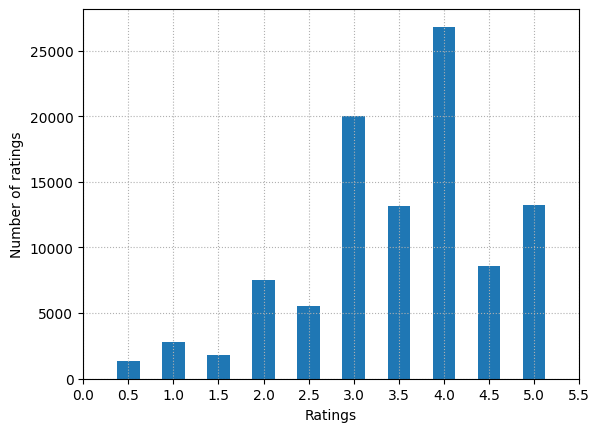

In [4]:
u, inv = np.unique(rating, return_inverse=True)
plt.bar(u, np.bincount(inv), width=0.25)
locs, labels = plt.xticks()  
plt.grid(linestyle=':')
plt.xticks(np.arange(0,6,0.5),rotation=0)
plt.ylabel('Number of ratings')
plt.xlabel('Ratings')
plt.savefig('../abhi_images/Q1B.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 1 (C)

### Number of ratings for each movie vs the movies (represented by their indices) (1-indexed disitribution) - ties are broken as per the functionality of np.argsort()

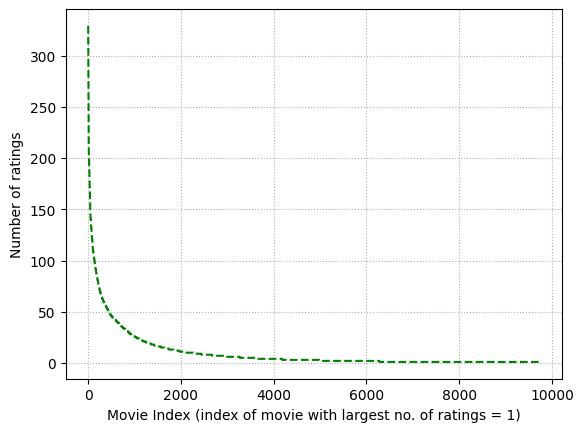

In [5]:
unique, counts = np.unique(movie_ID, return_counts=True)
plt.plot(range(1,len(unique)+1),counts[np.argsort(counts)[::-1]],linestyle='--',color='g')
plt.grid(linestyle=':')
plt.ylabel('Number of ratings')
plt.xlabel('Movie Index (index of movie with largest no. of ratings = 1)')
plt.savefig('../abhi_images/Q1C.png',dpi=300,bbox_inches='tight')
plt.show()

In [6]:
movie_count_dict = {} 
x = list(range(1,len(unique)+1))
for key in unique[np.argsort(counts)[::-1]]: 
    for value in x: 
        movie_count_dict[key] = value 
        x.remove(value) 
        break 
print('Top 5 rated movies (Movie ID, Index):')
print(list(movie_count_dict.items())[0:5])

Top 5 rated movies (Movie ID, Index):
[(356, 1), (318, 2), (296, 3), (593, 4), (2571, 5)]


# Question 1 (D)

### Number of ratings from each user vs the users (represented by their indices) (1-indexed disitribution) - ties are broken as per the functionality of np.argsort()

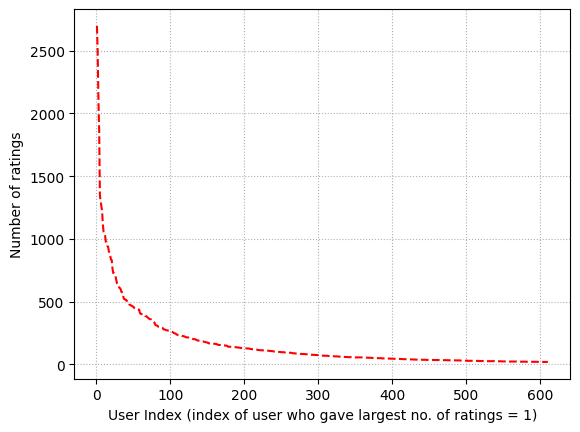

In [7]:
unique, counts = np.unique(user_ID, return_counts=True)
plt.plot(range(1,len(unique)+1),counts[np.argsort(counts)[::-1]],linestyle='--',color='r')
plt.grid(linestyle=':')
plt.ylabel('Number of ratings')
plt.xlabel('User Index (index of user who gave largest no. of ratings = 1)')
plt.savefig('../abhi_images/Q1D.png',dpi=300,bbox_inches='tight')
plt.show()

In [8]:
user_count_dict = {} 
x = list(range(1,len(unique)+1))
for key in unique[np.argsort(counts)[::-1]]: 
    for value in x: 
        user_count_dict[key] = value 
        x.remove(value) 
        break 
print('Top 5 users who rated most number of times (User ID, Index):')
print(list(user_count_dict.items())[0:5])

Top 5 users who rated most number of times (User ID, Index):
[(414, 1), (599, 2), (474, 3), (448, 4), (274, 5)]


# Question 1 (E)

### Both the “number of ratings per movie” and the “number of ratings submitted per user” exhibit strongly skewed, roughly exponential‐like distributions. A small fraction of movies gather a large number of ratings, while many movies receive only a handful. Likewise, a small subset of users rates a large number of movies, but most users contribute few ratings. This behavior leads to data sparsity in the overall ratings matrix. Large portions of the matrix remain unobserved because many users rate only a few movies, and many movies receive only a few ratings. As a result, any recommendation approach trained on such data must handle potential overfitting for popular (highly rated) items, while still making reasonable predictions for items with very few ratings. Likewise, models must handle users who generate limited information (few ratings) without ignoring them. Techniques such as regularization, smoothing, or relying on broader patterns (e.g., latent factors, side information) become valuable to address the risk of overfitting “popular” items and under‐representing the long tail of rare movies (and less active users). In summary, skewed sitributions lead to:

### Limited Overlaps:
### Many items are rated by only a few users, and many users only rate a few items. This leaves large parts of the user–item rating matrix blank, making it difficult to draw confident inferences for less‐rated items or less‐active users.

### Dependence on “Power Users” and “Popular Items”:
### The small fraction of highly active users contributes most of the rating volume, which can bias the system toward items those active users prefer. Similarly, methods that rely on common items or users might mostly capture the tastes of the small set of popular items and prolific raters.

### Long‐Tail Challenge:
### The long tail of infrequently rated items (and less active users) is essential to recommendation diversity and novelty, but the system sees little direct data about them, risking poor coverage or irrelevant recommendations for rare items.

### Risk of Overfitting:
### If a model or strategy focuses too strongly on the few “popular” items or “power users,” it may overfit to a small subset of the data and fail to generalize well for the many sparsely rated items or lightly engaged users.

### Cold‐Start / Sparsity Issues:
### Movies with only a handful of ratings and users who have rated very few items fall under a “cold start.” Additional techniques or external data may be needed to handle their sparse information effectively.

### Implications:

### Recommender systems must often regularize or smooth estimates (e.g., weighting, damping, or Bayesian priors) to avoid overspecializing on high‐frequency signals.
### Systems may include auxiliary information (e.g., textual descriptions, metadata, user demographics, or other side information) to mitigate the sparse overlaps and produce recommendations even for relatively obscure items and less‐active users.
### Dimensionality‐reduction or latent factor methods often prove helpful, as they leverage broader patterns in the data rather than depending exclusively on exact user‐item overlaps, which can be scarce for the long tail.
### The exponential‐like distributions highlight why sparsity and long‐tail effects are fundamental challenges for designing and evaluating any recommender system.

# Question 1 (F)

### Histogram of the variances:

In [9]:
unique_movie_ID = list(set(movie_ID))
movie_ID_list = []
var_list = []
for j in range(len(unique_movie_ID)):
    indices = [i for i, x in enumerate(movie_ID) if x == unique_movie_ID[j]]
    var = np.var(np.array(rating[indices]))
    movie_ID_list.append(unique_movie_ID[j])
    var_list.append(var)

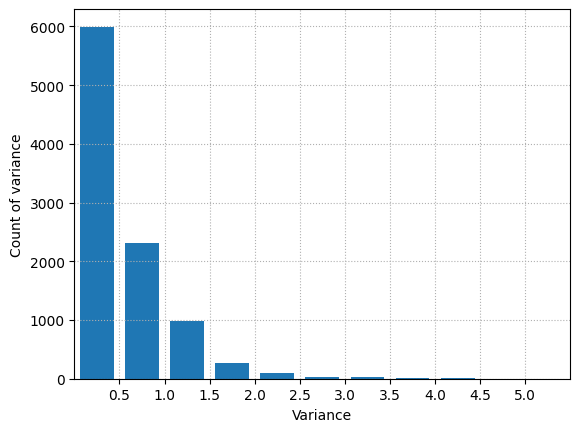

In [10]:
plt.hist(var_list, bins=np.arange(0,5.5,0.5),rwidth=0.75)
plt.xticks(np.arange(0.5,5.5,0.5))
plt.xlim([0, 5.5])
plt.grid(linestyle=':')
plt.xlabel('Variance')
plt.ylabel('Count of variance')
plt.savefig('../abhi_images/Q1F.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 2

### (A):

 $$
 \mu_u = \frac{\sum_{k \in I_u} r_{uk}}{\lvert I_u \rvert}
 $$


### (B):

### **Definition**: $ I_u \cap I_v $ indicates the set of movies (item indices) for which ratings have been specified by both user $u$ and user $v$. Therefore, $I_u \cap I_v$ can be an empty set (null) in a dataset like ours, because there may be some movies rated by user $u$ but not by user $v$, and vice versa.


# Question 3

### Centering each user’s ratings around their own average decreases user-specific bias and smooths out unusually high or low rating patterns. This is useful because some users consistently rate items near the top or bottom of the scale, whereas others spread their ratings across the entire range. By subtracting each user’s mean rating, we reduce variability caused by these individual rating tendencies, which in turn lowers noise and multicollinearity. Ultimately, mean-centering ensures that we focus on meaningful interactions among ratings rather than being skewed by outlier behavior or systematic bias from certain users.

# Question 4

### First we must clean the data a bit to remove the index column as it is not an attribute. Then we sweep our cross validation with k $ \in $ [2,100] and plot the avg. RMSE and MAE (one after the other) across all 10 folds for each k.

In [11]:
df = pd.read_csv('../data/Synthetic_Movie_Lens/ratings.csv', index_col=0)
df = df.reset_index(drop=True)  # If the first column was just the old index
df.to_csv('../data/Synthetic_Movie_Lens/ratings_fixed.csv', index=False)
df.head()

,userId,movieId,rating,timestamp
0,496,112852,3.0,1415520462
1,391,1947,4.0,1030945141
2,387,1562,1.5,1095041022
3,474,2716,4.5,1053020930
4,483,88125,4.5,1311337237


In [12]:
reader = Reader(line_format='user item rating timestamp',sep=',',rating_scale=(0.5, 5),skip_lines=1)
ratings_dataset = Dataset.load_from_file(dataset_folder+"ratings_fixed.csv",reader=reader)

In [13]:
k = np.arange(2,102,2)
rmse = []
mae = []
for item in k:
    print('Testing for k =',item)
    res = cross_validate(KNNWithMeans(k=item,sim_options={'name':'pearson', 'user_based': True}),
                         measures=['rmse','mae'],data = ratings_dataset,cv=10,n_jobs=-1)   
    rmse.append(np.mean(res['test_rmse']))
    mae.append(np.mean(res['test_mae']))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50
Testing for k = 52
Testing for k = 54
Testing for k = 56
Testing for k = 58
Testing for k = 60
Testing for k = 62
Testing for k = 64
Testing for k = 66
Testing for k = 68
Testing for k = 70
Testing for k = 72
Testing for k = 74
Testing for k = 76
Testing for k = 78
Testing for k = 80
Testing for k = 82
Testing for k = 84
Testing for k = 86
Testing for k = 88
Testing for k = 90
Testing for k = 92
Testing for k = 94
Testing for k = 96
Testing for k = 98
Testing for k = 100


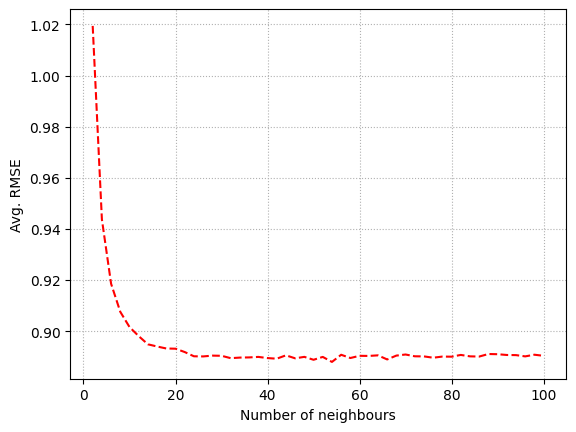

In [14]:
plt.plot(k,rmse,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.savefig('../abhi_images/Q4A.png',dpi=300,bbox_inches='tight')
plt.show()

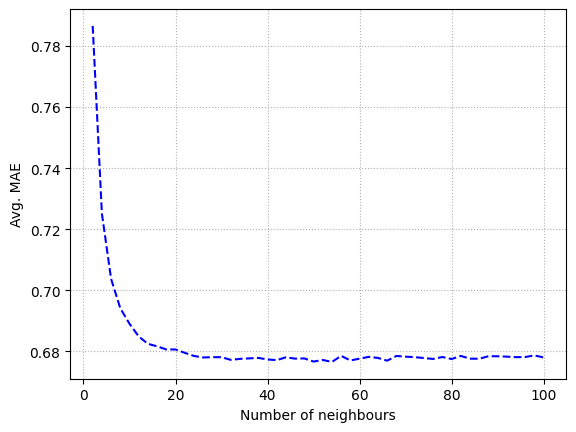

In [15]:
plt.plot(k,mae,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.ylabel('Avg. MAE')
plt.xlabel('Number of neighbours')
plt.savefig('../abhi_images/Q4B.png',dpi=300,bbox_inches='tight')
plt.show()

# Question 5

### Judging from the curves in Question 4, we see that the steady state occurs at k = 20, with the steady-state RMSE = 0.8926 and steady-state MAE = 0.6799. So, k = 20 is our 'minimum k'

In [16]:
print(f'RMSE at k=20: {rmse[9]}')
print(f'MAE at k=20: {mae[9]}')

RMSE at k=20: 0.8931874735689023
MAE at k=20: 0.6806297276068325


# Question 6

### The avg RMSE across all folds vs k is plotted, and the min avg RMSE and the corresponding k values are printed for each trimmed subset of our data. After that we use the k's corresponding to the min avg RMSE for each subset (and k = 20 for full untrimmed data) to plot their ROCs (4 plots with all 4 thresholds on each plot). Min avg RMSE values are summarised in the following table:

| **Subset**        | **Best k** | **Min Avg RMSE** |
|-------------------|-----------:|-----------------:|
| **Popular**       | 42         | 0.8702           |
| **Unpopular**     | 2          | 1.0637           |
| **High-Variance** | 2          | 1.5038           |


k-sweep: 100%|██████████| 50/50 [19:28<00:00, 23.37s/it]

=== Popular Subset ===
Best k: 42, Min Avg RMSE: 0.8702


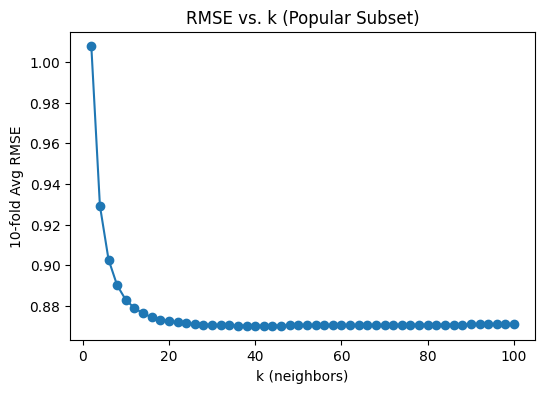

k-sweep: 100%|██████████| 50/50 [00:26<00:00,  1.87it/s]


=== Unpopular Subset ===
Best k: 2, Min Avg RMSE: 1.0637


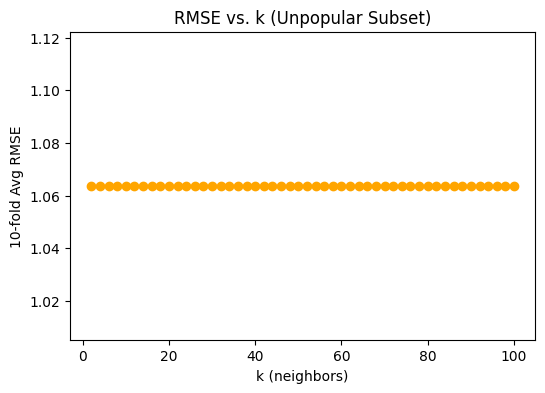

k-sweep: 100%|██████████| 50/50 [00:02<00:00, 22.29it/s]


=== High-Variance Subset ===
Best k: 2, Min Avg RMSE: 1.5038


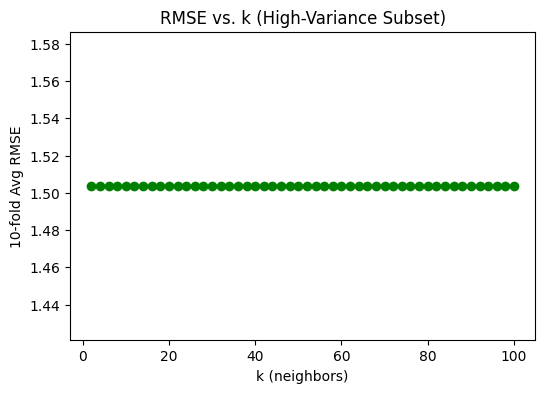

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from tqdm import tqdm
from surprise import Dataset, Reader, KNNWithMeans, accuracy
from surprise.model_selection import KFold

def trim_data(raw_data, method='popular', rating_threshold=2, var_threshold=2.0, min_var_count=5):
    item_ratings = defaultdict(list)
    for (u, i, r, t) in raw_data:
        item_ratings[i].append(r)
    if method == 'popular':
        keep_items = {i for i, rlist in item_ratings.items() if len(rlist) > rating_threshold}
    elif method == 'unpopular':
        keep_items = {i for i, rlist in item_ratings.items() if len(rlist) <= rating_threshold}
    elif method == 'high_variance':
        keep_items = []
        for i, rlist in item_ratings.items():
            if len(rlist) >= min_var_count and np.var(rlist) >= var_threshold:
                keep_items.append(i)
        keep_items = set(keep_items)
    else:
        raise ValueError("method must be 'popular', 'unpopular', or 'high_variance'")
    trimmed = [(u, i, r, t) for (u, i, r, t) in raw_data if i in keep_items]
    return trimmed

def evaluate_knn_for_subset(trimmed_raw_data, k_values, user_based=True):
    df = pd.DataFrame(trimmed_raw_data, columns=['userID','itemID','rating','timestamp'])
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userID','itemID','rating']], reader)
    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    rmse_results = []
    for k in tqdm(k_values, desc="k-sweep"):
        fold_rmse = []
        for trainset, testset in tqdm(kf.split(data), desc=f"(k={k}) folds", leave=False):
            algo = KNNWithMeans(k=k, sim_options={'name': 'pearson','user_based': user_based}, verbose=False)
            algo.fit(trainset)
            predictions = algo.test(testset)
            fold_rmse.append(accuracy.rmse(predictions, verbose=False))
        rmse_results.append(np.mean(fold_rmse))
    return rmse_results

full_data_raw = ratings_dataset.raw_ratings
popular_data_raw = trim_data(full_data_raw, method='popular', rating_threshold=2)
unpopular_data_raw = trim_data(full_data_raw, method='unpopular', rating_threshold=2)
high_var_data_raw = trim_data(full_data_raw, method='high_variance', var_threshold=2.0, min_var_count=5)

k_values = list(range(2, 101, 2))

rmse_popular = evaluate_knn_for_subset(popular_data_raw, k_values, user_based=True)
best_k_popular = k_values[np.argmin(rmse_popular)]
best_rmse_popular = min(rmse_popular)
print("=== Popular Subset ===")
print(f"Best k: {best_k_popular}, Min Avg RMSE: {best_rmse_popular:.4f}")
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_popular, marker='o')
plt.title("RMSE vs. k (Popular Subset)")
plt.xlabel("k (neighbors)")
plt.ylabel("10-fold Avg RMSE")
plt.show()

rmse_unpopular = evaluate_knn_for_subset(unpopular_data_raw, k_values, user_based=True)
best_k_unpopular = k_values[np.argmin(rmse_unpopular)]
best_rmse_unpopular = min(rmse_unpopular)
print("=== Unpopular Subset ===")
print(f"Best k: {best_k_unpopular}, Min Avg RMSE: {best_rmse_unpopular:.4f}")
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_unpopular, marker='o', color='orange')
plt.title("RMSE vs. k (Unpopular Subset)")
plt.xlabel("k (neighbors)")
plt.ylabel("10-fold Avg RMSE")
plt.show()

rmse_highvar = evaluate_knn_for_subset(high_var_data_raw, k_values, user_based=True)
best_k_highvar = k_values[np.argmin(rmse_highvar)]
best_rmse_highvar = min(rmse_highvar)
print("=== High-Variance Subset ===")
print(f"Best k: {best_k_highvar}, Min Avg RMSE: {best_rmse_highvar:.4f}")
plt.figure(figsize=(6,4))
plt.plot(k_values, rmse_highvar, marker='o', color='green')
plt.title("RMSE vs. k (High-Variance Subset)")
plt.xlabel("k (neighbors)")
plt.ylabel("10-fold Avg RMSE")
plt.show()


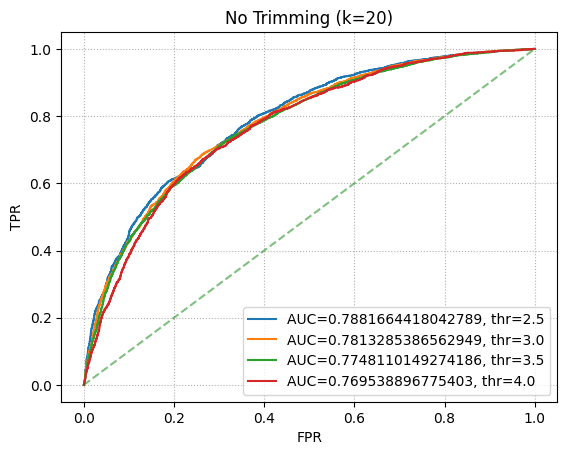

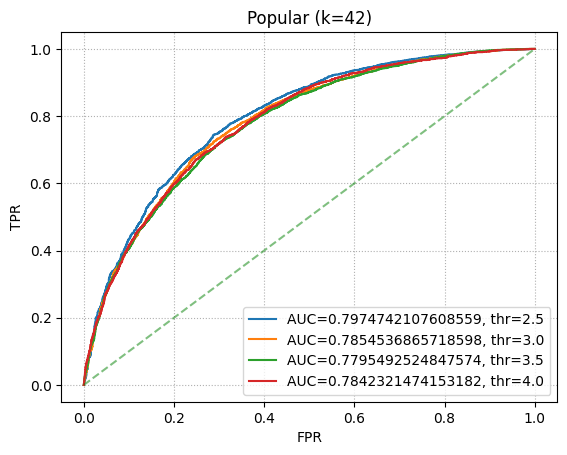

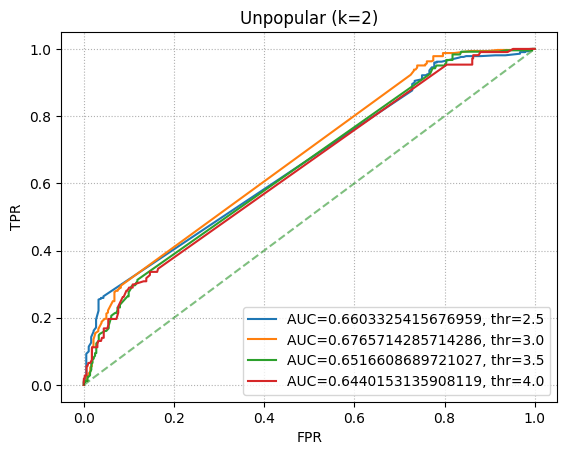

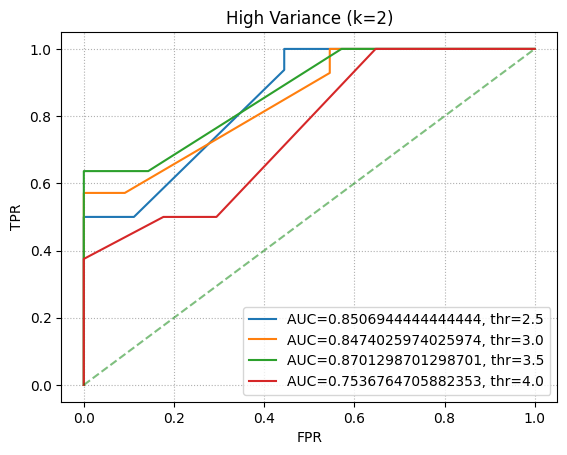

In [23]:
thres=[2.5,3.0,3.5,4.0]
raw_full=ratings_dataset.raw_ratings
df_full=pd.DataFrame(raw_full,columns=['u','i','r','t'])
reader=Reader(rating_scale=(0.5,5))
data_full=Dataset.load_from_df(df_full[['u','i','r']],reader)
trainf,testf=train_test_split(data_full,test_size=0.1)
algof=KNNWithMeans(k=20,sim_options={'name':'pearson'},verbose=False).fit(trainf)
resf=algof.test(testf)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resf]
    fpr,tpr,_=roc_curve(y,[row.est for row in resf])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('No Trimming (k=20)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

raw_pop=trim_data(raw_full,'popular',2)
df_pop=pd.DataFrame(raw_pop,columns=['u','i','r','t'])
data_pop=Dataset.load_from_df(df_pop[['u','i','r']],reader)
trainp,testp=train_test_split(data_pop,test_size=0.1)
algop=KNNWithMeans(k=best_k_popular,sim_options={'name':'pearson'},verbose=False).fit(trainp)
resp=algop.test(testp)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resp]
    fpr,tpr,_=roc_curve(y,[row.est for row in resp])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title(f'Popular (k={best_k_popular})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

raw_unp=trim_data(raw_full,'unpopular',2)
df_unp=pd.DataFrame(raw_unp,columns=['u','i','r','t'])
data_unp=Dataset.load_from_df(df_unp[['u','i','r']],reader)
trainu,testu=train_test_split(data_unp,test_size=0.1)
algou=KNNWithMeans(k=best_k_unpopular,sim_options={'name':'pearson'},verbose=False).fit(trainu)
resu=algou.test(testu)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resu]
    fpr,tpr,_=roc_curve(y,[row.est for row in resu])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title(f'Unpopular (k={best_k_unpopular})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

raw_hv=trim_data(raw_full,'high_variance',2,2.0,5)
df_hv=pd.DataFrame(raw_hv,columns=['u','i','r','t'])
data_hv=Dataset.load_from_df(df_hv[['u','i','r']],reader)
trainh,testh=train_test_split(data_hv,test_size=0.1)
algoh=KNNWithMeans(k=best_k_highvar,sim_options={'name':'pearson'},verbose=False).fit(trainh)
resh=algoh.test(testh)
fig,ax=plt.subplots()
for x in thres:
    y=[1 if row.r_ui>x else 0 for row in resh]
    fpr,tpr,_=roc_curve(y,[row.est for row in resh])
    ax.plot(fpr,tpr,label="AUC="+str(auc(fpr,tpr))+", thr="+str(x))
ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title(f'High Variance (k={best_k_highvar})')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

# Question 7

### The optimization problem is **not jointly convex** for the user latent space $U$ and the item embedding space $V$ due to multiple local minima in the objective function’s gradient landscape. This is because the matrix factorization model predicts ratings through the product $UV^T$, which does not satisfy the convexity property—its objective function is permutation and rotation invariant.

### A common approach to solve this problem is **alternating least-squares (ALS)**: fix $U$ and solve for $V$, then fix $V$ and solve for $U$. For a fixed $U$, the least-squares formulation of the objective function (omitting regularization) is:

$$
\min_V \sum_{i=1}^{m} \sum_{j=1}^{n} W_{ij}\bigl(r_{ij} - (UV^T)_{ij}\bigr)^2,
$$

### and the solution is:

$$
V = \bigl(UU^T\bigr)^{-1}\,U\,R,
$$

### where $R$ is the ratings matrix.



# Question 8

# PART A

### Plots can be found below:

In [23]:
k = np.arange(2,52,2)
rmse_NMF_50 = []
mae_NMF_50 = []
for item in k:
    print('Testing for k =',item)
    res = cross_validate(NMF(n_factors=item,n_epochs=50,verbose=False),
                         measures=['rmse','mae'],data = ratings_dataset,cv=10,n_jobs=-1)   
    rmse_NMF_50.append(np.mean(res['test_rmse']))
    mae_NMF_50.append(np.mean(res['test_mae']))

Testing for k = 2
Testing for k = 4
Testing for k = 6
Testing for k = 8
Testing for k = 10
Testing for k = 12
Testing for k = 14
Testing for k = 16
Testing for k = 18
Testing for k = 20
Testing for k = 22
Testing for k = 24
Testing for k = 26
Testing for k = 28
Testing for k = 30
Testing for k = 32
Testing for k = 34
Testing for k = 36
Testing for k = 38
Testing for k = 40
Testing for k = 42
Testing for k = 44
Testing for k = 46
Testing for k = 48
Testing for k = 50


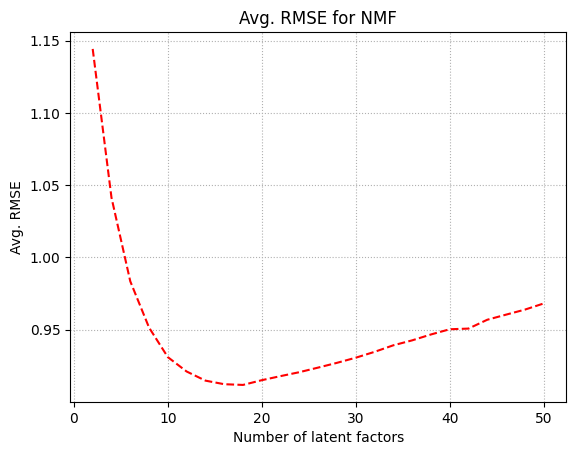

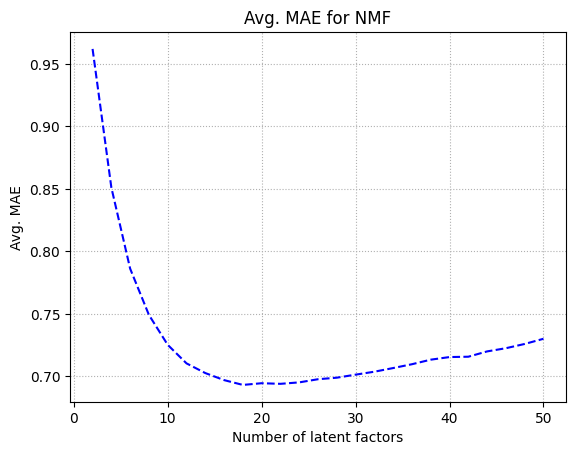

In [25]:
plt.plot(k,rmse_NMF_50,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE for NMF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of latent factors')
#plt.savefig('../abhi_images/Q8A_RMSE.png',dpi=300,bbox_inches='tight')
plt.show()

plt.plot(k,mae_NMF_50,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Avg. MAE for NMF')
plt.ylabel('Avg. MAE')
plt.xlabel('Number of latent factors')
#plt.savefig('../abhi_images/Q8A_MAE.png',dpi=300,bbox_inches='tight')
plt.show()


In [38]:
print("Minimum avg. RMSE (NMF): %f, value of k: %d" % (min(rmse_NMF_50),k[np.argmin(rmse_NMF_50)]))
print("Minimum avg. MAE (NMF): %f, value of k: %d" % (min(mae_NMF_50), k[np.argmin(mae_NMF_50)]))

Minimum avg. RMSE (NMF): 0.911686, value of k: 18
Minimum avg. MAE (NMF): 0.693172, value of k: 18


# PART B

### Since both RMSE and MAE plots reveal that the optimal k (which returns minimum value for both) is k = 18, we shall use this as out optimal value to plot the ROC - further, this value is actually close to the number of genres that was printed at the start of this report.

# PART C

### The plots can be seen below and the min avg RMSE and corresponding k values are summarised below:


| **Subset** | **Best k** | **Min RMSE** |
|------------|-----------|--------------|
| Popular    | 20        | 0.8938076299869282 |
| Unpopular  | 44        | 1.1340514349876818 |
| High Var   | 20        | 1.5726049136610523 |

### Note that we are using the best k's to plot the ROC


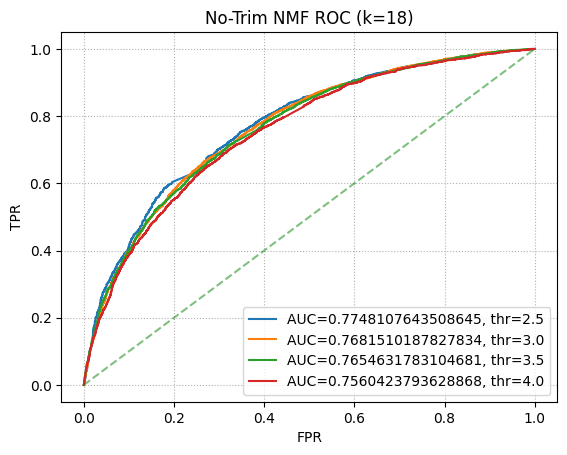

Sweeping factors: 100%|██████████| 25/25 [38:19<00:00, 91.98s/it] 


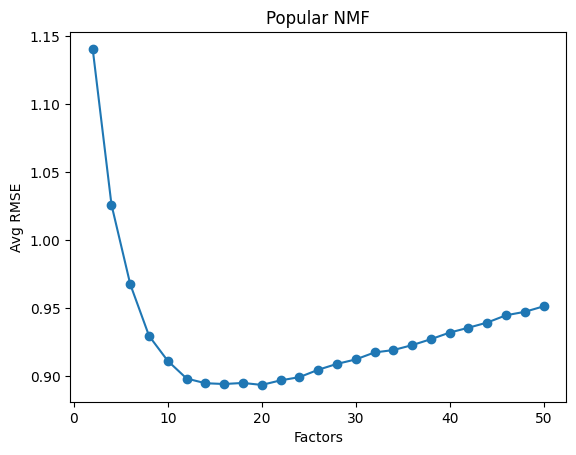

Popular best factors: 20 Min RMSE: 0.8938076299869282


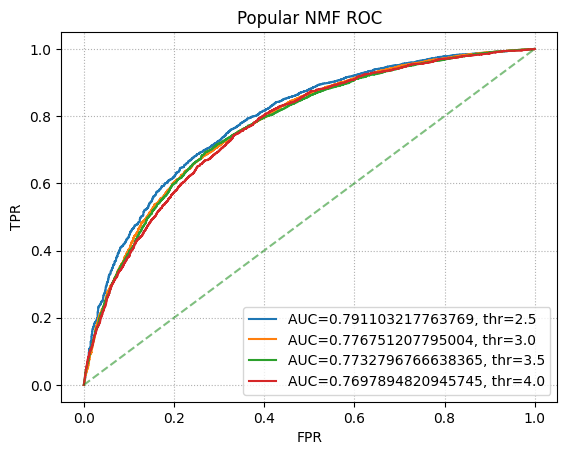

Sweeping factors: 100%|██████████| 25/25 [04:42<00:00, 11.29s/it]


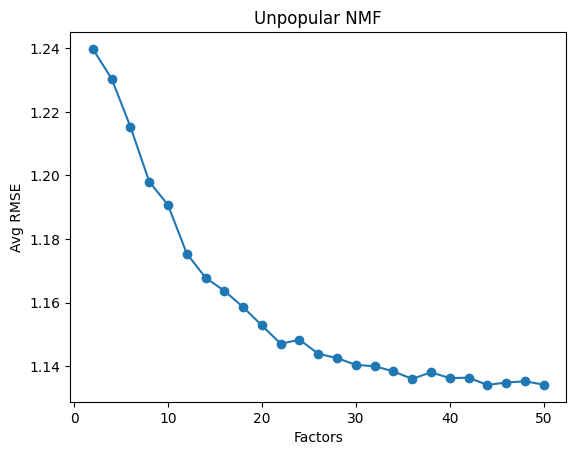

Unpopular best factors: 44 Min RMSE: 1.1340514349876818


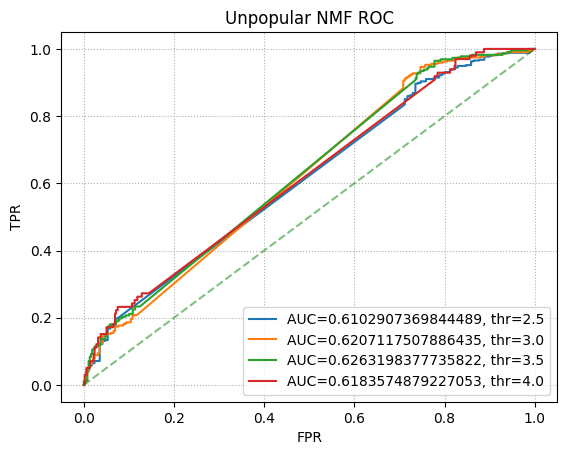

Sweeping factors: 100%|██████████| 25/25 [00:08<00:00,  2.83it/s]


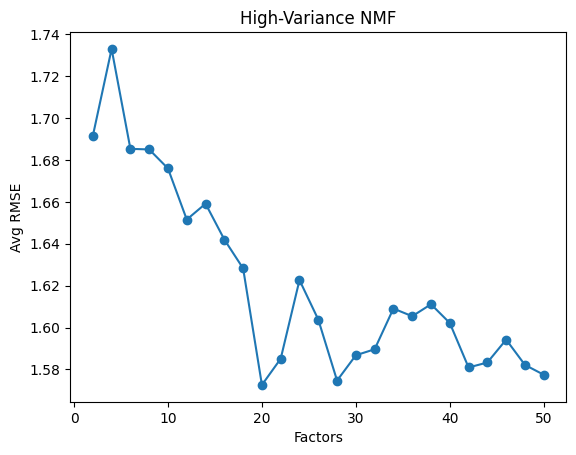

High Var best factors: 20 Min RMSE: 1.5726049136610523


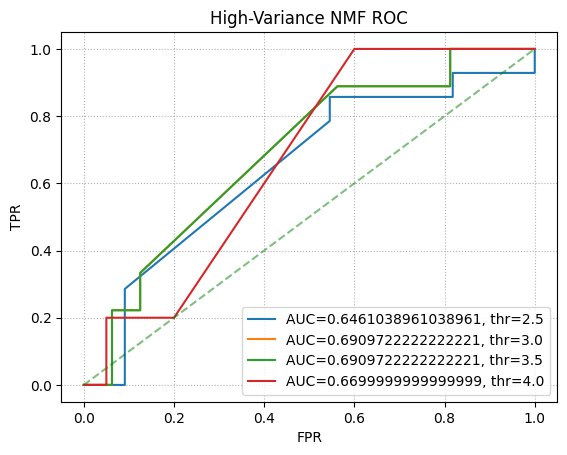

In [40]:
from tqdm import tqdm

def trim_data(raw_data, method='popular', rating_threshold=2, var_threshold=2.0, min_var_count=5):
    d = defaultdict(list)
    for (u,i,r,t) in raw_data:
        d[i].append(r)
    if method == 'popular':
        keep = {i for i in d if len(d[i]) > rating_threshold}
    elif method == 'unpopular':
        keep = {i for i in d if len(d[i]) <= rating_threshold}
    elif method == 'high_variance':
        keep = []
        for i in d:
            if len(d[i]) >= min_var_count and np.var(d[i]) >= var_threshold:
                keep.append(i)
        keep = set(keep)
    else:
        raise ValueError
    return [(u,i,r,t) for (u,i,r,t) in raw_data if i in keep]

def evaluate_nmf_10fold(trimmed_raw_data):
    df = pd.DataFrame(trimmed_raw_data, columns=['userID','itemID','rating','timestamp'])
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userID','itemID','rating']], reader)
    k_values = range(2, 51, 2)
    kf = KFold(n_splits=10, random_state=0, shuffle=True)
    rmse_results = []
    for k in tqdm(k_values, desc="Sweeping factors"):
        fold_rmse = []
        for trainset, testset in kf.split(data):
            algo = NMF(n_factors=k, n_epochs=50, verbose=False)
            algo.fit(trainset)
            preds = algo.test(testset)
            fold_rmse.append(accuracy.rmse(preds, verbose=False))
        rmse_results.append(np.mean(fold_rmse))
    return k_values, rmse_results, df

def plot_roc_nmf(df, best_k, title):
    reader = Reader(rating_scale=(0.5, 5))
    data = Dataset.load_from_df(df[['userID','itemID','rating']], reader)
    trainset, testset = train_test_split(data, test_size=0.1, random_state=0)
    algo = NMF(n_factors=best_k, n_epochs=50, verbose=False)
    algo.fit(trainset)
    preds = algo.test(testset)
    thresholds = [2.5, 3.0, 3.5, 4.0]
    fig, ax = plt.subplots()
    for t in thresholds:
        y_true = [1 if p.r_ui > t else 0 for p in preds]
        y_score = [p.est for p in preds]
        fpr, tpr, _ = roc_curve(y_true, y_score)
        ax.plot(fpr, tpr, label="AUC="+str(auc(fpr,tpr))+", thr="+str(t))
    ax.plot([0,1],[0,1],'--',color='g',alpha=.5)
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.grid(linestyle=':')
    plt.show()

raw_data = ratings_dataset.raw_ratings

df_full = pd.DataFrame(raw_data, columns=['userID','itemID','rating','timestamp'])
reader = Reader(rating_scale=(0.5, 5))
data_full = Dataset.load_from_df(df_full[['userID','itemID','rating']], reader)
plot_roc_nmf(df_full, 18, "No-Trim NMF ROC (k=18)")

pop_data = trim_data(raw_data, 'popular', 2)
kp, rp, dfp = evaluate_nmf_10fold(pop_data)
best_kp = kp[np.argmin(rp)]
plt.plot(kp, rp, marker='o')
plt.title('Popular NMF')
plt.xlabel('Factors')
plt.ylabel('Avg RMSE')
plt.show()
print("Popular best factors:", best_kp, "Min RMSE:", min(rp))
plot_roc_nmf(dfp, best_kp, 'Popular NMF ROC')

unp_data = trim_data(raw_data, 'unpopular', 2)
ku, ru, dfu = evaluate_nmf_10fold(unp_data)
best_ku = ku[np.argmin(ru)]
plt.plot(ku, ru, marker='o')
plt.title('Unpopular NMF')
plt.xlabel('Factors')
plt.ylabel('Avg RMSE')
plt.show()
print("Unpopular best factors:", best_ku, "Min RMSE:", min(ru))
plot_roc_nmf(dfu, best_ku, 'Unpopular NMF ROC')

hv_data = trim_data(raw_data, 'high_variance', 2, 2.0, 5)
kh, rh, dfh = evaluate_nmf_10fold(hv_data)
best_kh = kh[np.argmin(rh)]
plt.plot(kh, rh, marker='o')
plt.title('High-Variance NMF')
plt.xlabel('Factors')
plt.ylabel('Avg RMSE')
plt.show()
print("High Var best factors:", best_kh, "Min RMSE:", min(rh))
plot_roc_nmf(dfh, best_kh, 'High-Variance NMF ROC')


# Question 9

### We plot the top 10 for each column below. 

### From the genre list, we see that the top 10 movies in each column of V tend to belong to a small, focused set of genres. For example:

### Latent Factor 8 features many Comedy titles (e.g., “Comedy”, “Comedy|Crime”).
### Latent Factor 17 frequently highlights Action, and Horror motifs (e.g., “Horror|Thriller”, “Action|Crime|Drama|Thriller”).
### These clusters suggest that each latent factor captures a specific “theme” or “genre blend.” Items grouped under the same factor often share overlapping genres, indicating that the factorization naturally organizes movies by genre or broader thematic elements that users rate similarly.

In [27]:
genre = pd.read_csv(dataset_folder+'movies.csv',usecols=['movieId','title','genres'])
trainset, testset = train_test_split(ratings_dataset, test_size=0.1)
nmf = NMF(n_factors=20,n_epochs=50,verbose=False)
nmf.fit(trainset).test(testset)
U = nmf.pu
V = nmf.qi

cols = [i for i in range(20)]
for item in cols:
    print('Column number of V: ',item)
    selected_col = V[:,item]
    sorted_col = np.argsort(selected_col)[::-1]
    for i in sorted_col[0:10]:
        print(genre['genres'][i])
    print('---------------------------------------------')

Column number of V:  0
Comedy
Drama
Drama|Romance
Comedy
Adventure|Drama|Sci-Fi
Action|Comedy|Drama|War
Action|Adventure|Comedy|Sci-Fi
Documentary
Comedy|Drama|Romance
Comedy|Drama|Romance
---------------------------------------------
Column number of V:  1
Adventure|Sci-Fi|Thriller
Comedy
Crime|Drama|Thriller
Action|Horror|Thriller
Drama|Mystery
Drama
Action|Crime
Action|Drama|Romance|War
Comedy
Comedy|Drama|Romance
---------------------------------------------
Column number of V:  2
Comedy|Romance
Action|Sci-Fi
Comedy|Crime
Action|Adventure|Drama|Thriller
Thriller
Drama|Romance
Musical
Comedy
Drama|Romance
Mystery|Thriller
---------------------------------------------
Column number of V:  3
Action|Crime|Drama|Thriller
Comedy|Drama|Romance
Comedy|Drama
Drama
Adventure|Drama|Romance
Action|Drama|Thriller
Drama|War
Action|Comedy|Crime|Drama
Comedy|Drama
Adventure|Comedy|Thriller
---------------------------------------------
Column number of V:  4
Horror
Comedy|Romance
Adventure|Children

# Question 10

### Plots are reported one after another for full-data, popular, unpopular and high-variance subsets respectively. RMSE and MAE results are summarised as follows:

**Full Data**  
- Min RMSE = 0.8652 at k = 26  
- Min MAE  = 0.6642 at k = 36  
- Chosen k (closest to 19 unique genres) = 26

| Subset     | Best k (RMSE) | Min RMSE | Best k (MAE) | Min MAE | Chosen k |
|------------|:------------:|:--------:|:------------:|:-------:|:--------:|
| Full Data  | 26           | 0.8652   | 36           | 0.6642  | 26       |

---

**Popular Subset**  
- Best RMSE = 0.8559 at k = 32

**Unpopular Subset**  
- Best RMSE = 0.8953 at k = 6

**High-Variance Subset**  
- Best RMSE = 1.5611 at k = 40

| Subset          | Best k | Min RMSE |
|-----------------|:------:|:--------:|
| Popular         | 32     | 0.8559   |
| Unpopular       | 6      | 0.8953   |
| High-Variance   | 40     | 1.5611   |


Full Data k-sweep: 100%|██████████| 25/25 [10:08<00:00, 24.35s/it]

Full Data - Min RMSE=0.8652 at k=26
Full Data - Min MAE =0.6642 at k=36
Chosen k by closeness to 19: 26


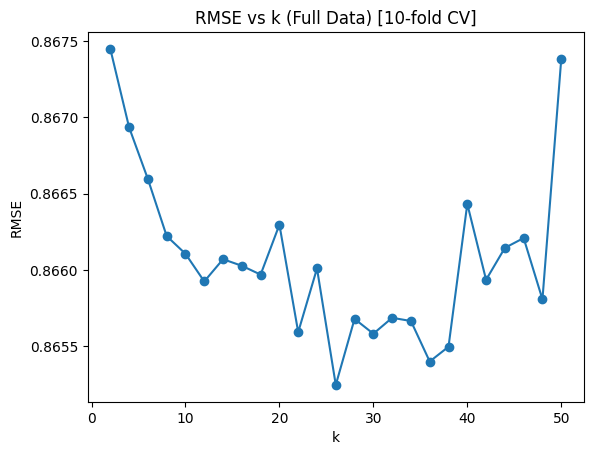

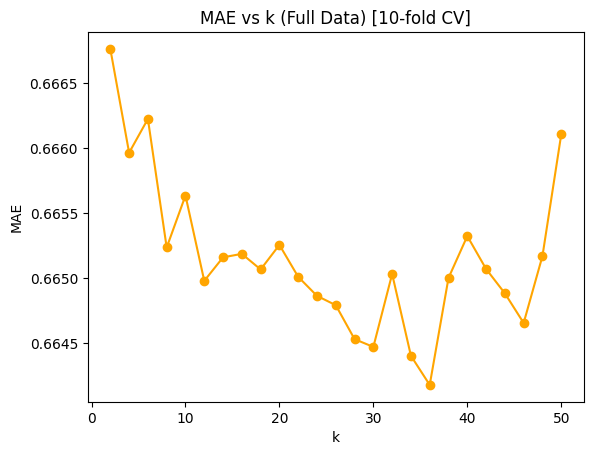

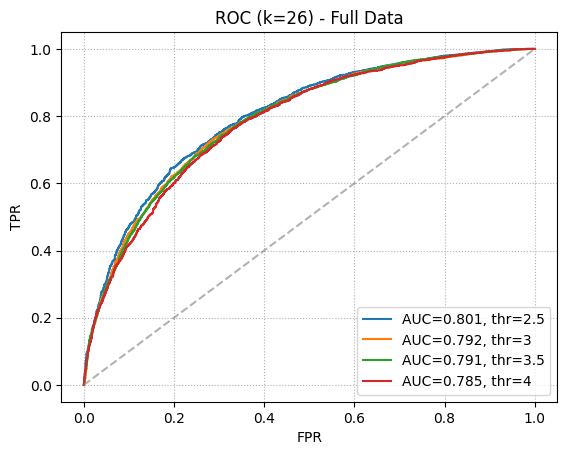

Popular k-sweep: 100%|██████████| 25/25 [13:57<00:00, 33.50s/it]

Popular Subset - Best RMSE=0.8559 at k=32


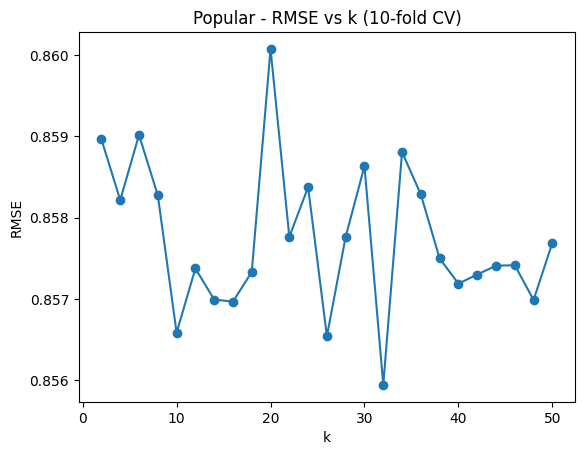

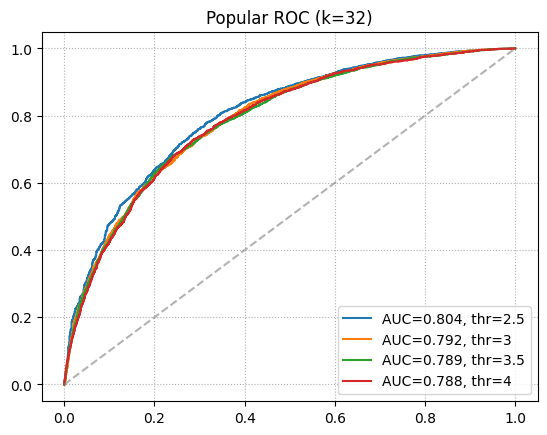

Unpopular k-sweep: 100%|██████████| 25/25 [00:52<00:00,  2.08s/it]

Unpopular Subset - Best RMSE=0.8953 at k=6


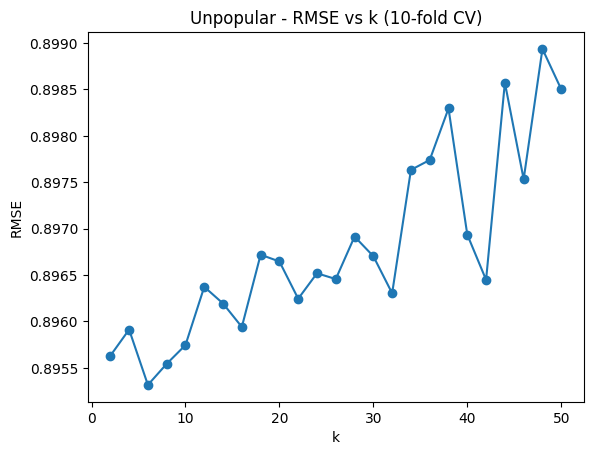

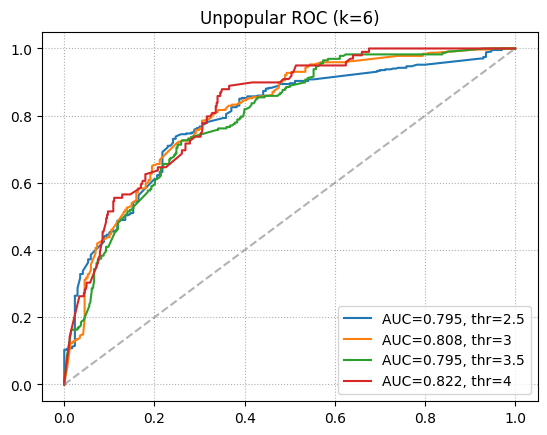

High-Variance k-sweep: 100%|██████████| 25/25 [00:02<00:00, 11.99it/s]


High-Variance Subset - Best RMSE=1.5611 at k=40


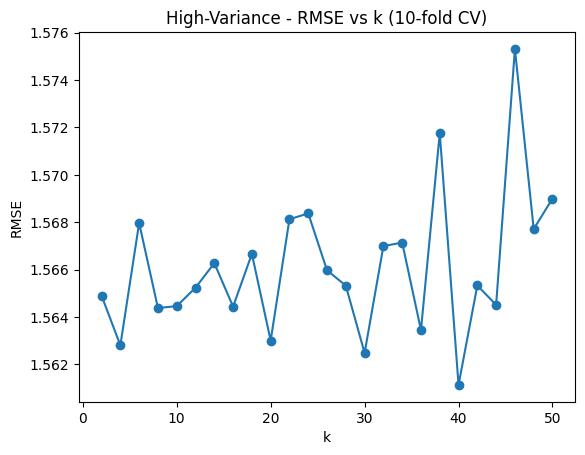

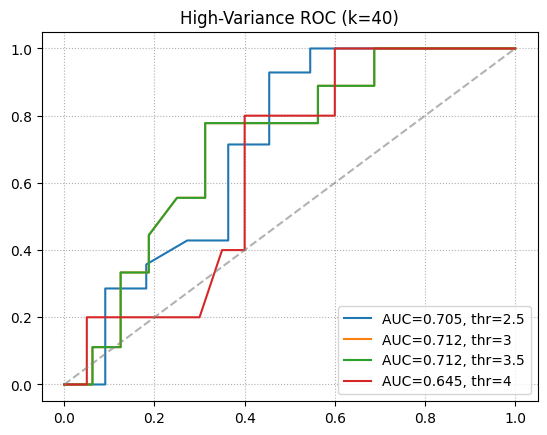

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from surprise import SVD, Dataset, Reader, accuracy
from surprise.model_selection import cross_validate, train_test_split, KFold
from sklearn.metrics import roc_curve, auc

k_values = np.arange(2,52,2)
rmse_SVD = []
mae_SVD = []
for k in tqdm(k_values,desc="Full Data k-sweep"):
    res = cross_validate(
        SVD(n_factors=k,n_epochs=20,verbose=False),
        data=ratings_dataset,
        measures=['rmse','mae'],
        cv=10,
        n_jobs=-1
    )
    rmse_SVD.append(np.mean(res['test_rmse']))
    mae_SVD.append(np.mean(res['test_mae']))

min_rmse_full = min(rmse_SVD)
min_mae_full = min(mae_SVD)
best_k_rmse = k_values[np.argmin(rmse_SVD)]
best_k_mae = k_values[np.argmin(mae_SVD)]

def dist19(x): return abs(x-19)
chosen_k = min([best_k_rmse,best_k_mae], key=dist19)

print(f"Full Data - Min RMSE={min_rmse_full:.4f} at k={best_k_rmse}")
print(f"Full Data - Min MAE ={min_mae_full:.4f} at k={best_k_mae}")
print(f"Chosen k by closeness to 19: {chosen_k}")

plt.plot(k_values,rmse_SVD,marker='o')
plt.title("RMSE vs k (Full Data) [10-fold CV]")
plt.xlabel("k")
plt.ylabel("RMSE")
plt.show()

plt.plot(k_values,mae_SVD,marker='o',color='orange')
plt.title("MAE vs k (Full Data) [10-fold CV]")
plt.xlabel("k")
plt.ylabel("MAE")
plt.show()

trainset, testset = train_test_split(ratings_dataset, test_size=0.1, random_state=0)
algo = SVD(n_factors=chosen_k, n_epochs=20, verbose=False, random_state=0)
algo.fit(trainset)
predictions = algo.test(testset)

thresholds = [2.5,3,3.5,4]
plt.figure()
for t in thresholds:
    y_true = [1 if p.r_ui>t else 0 for p in predictions]
    y_score = [p.est for p in predictions]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.plot(fpr, tpr, label=f"AUC={auc(fpr,tpr):.3f}, thr={t}")
plt.plot([0,1],[0,1],'--',color='gray',alpha=0.6)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"ROC (k={chosen_k}) - Full Data")
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.show()

def trim_data(raw_data,method='popular',rating_threshold=2,var_threshold=2.0,min_var_count=5):
    from collections import defaultdict
    d = defaultdict(list)
    for (u,i,r,t) in raw_data:
        d[i].append(r)
    if method=='popular':
        keep = {i for i in d if len(d[i])>rating_threshold}
    elif method=='unpopular':
        keep = {i for i in d if len(d[i])<=rating_threshold}
    elif method=='high_variance':
        keep = []
        for i in d:
            if len(d[i])>=min_var_count and np.var(d[i])>=var_threshold:
                keep.append(i)
        keep = set(keep)
    else:
        raise ValueError("Unknown trim method")
    return [(u,i,r,t) for (u,i,r,t) in raw_data if i in keep]

def to_dataset(data):
    df = pd.DataFrame(data,columns=['userID','itemID','rating','timestamp'])
    return Dataset.load_from_df(df[['userID','itemID','rating']],Reader(rating_scale=(0.5,5)))

pop_dataset = to_dataset(trim_data(ratings_dataset.raw_ratings,'popular',2))
unp_dataset = to_dataset(trim_data(ratings_dataset.raw_ratings,'unpopular',2))
hv_dataset  = to_dataset(trim_data(ratings_dataset.raw_ratings,'high_variance',2,2.0,5))

def process_subset(ds,title):
    kf = KFold(n_splits=10,shuffle=True,random_state=0)
    kvals = np.arange(2,52,2)
    mean_rmses = []
    for k in tqdm(kvals,desc=f"{title} k-sweep"):
        fold_rmses = []
        for trn,tst in tqdm(kf.split(ds),desc=f"{title} folds for k={k}",leave=False):
            algo = SVD(n_factors=k,n_epochs=20,verbose=False, random_state=0)
            algo.fit(trn)
            preds = algo.test(tst)
            fold_rmses.append(accuracy.rmse(preds,verbose=False))
        mean_rmses.append(np.mean(fold_rmses))
    bestk = kvals[np.argmin(mean_rmses)]
    min_rmse = min(mean_rmses)
    print(f"{title} Subset - Best RMSE={min_rmse:.4f} at k={bestk}")
    plt.plot(kvals,mean_rmses,marker='o')
    plt.title(f"{title} - RMSE vs k (10-fold CV)")
    plt.xlabel("k")
    plt.ylabel("RMSE")
    plt.show()
    trn2,tst2 = train_test_split(ds,test_size=0.1,random_state=0)
    algo = SVD(n_factors=bestk,n_epochs=20,verbose=False, random_state=0)
    algo.fit(trn2)
    preds = algo.test(tst2)
    thresholds = [2.5,3,3.5,4]
    plt.figure()
    for thr in thresholds:
        y_true = [1 if p.r_ui>thr else 0 for p in preds]
        y_score = [p.est for p in preds]
        fpr,tpr,_ = roc_curve(y_true,y_score)
        plt.plot(fpr,tpr,label=f"AUC={auc(fpr,tpr):.3f}, thr={thr}")
    plt.plot([0,1],[0,1],'--',color='gray',alpha=0.6)
    plt.title(f"{title} ROC (k={bestk})")
    plt.legend(loc='best')
    plt.grid(linestyle=':')
    plt.show()

process_subset(pop_dataset,"Popular")
process_subset(unp_dataset,"Unpopular")
process_subset(hv_dataset,"High-Variance")


# Question 11

### Summary of results:

| **Subset**     | **10-fold CV Avg RMSE** |
|----------------|-------------------------|
| Full Data      | 0.9347                 |
| Popular        | 0.9308                 |
| Unpopular      | 0.8408                 |
| High-Variance  | 0.7973                 |


Full Data - 10-fold CV - Avg RMSE: 0.9347


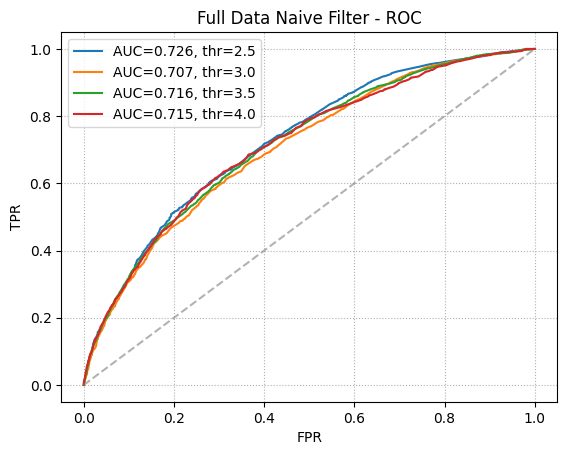

Popular - 10-fold CV - Avg RMSE: 0.9308


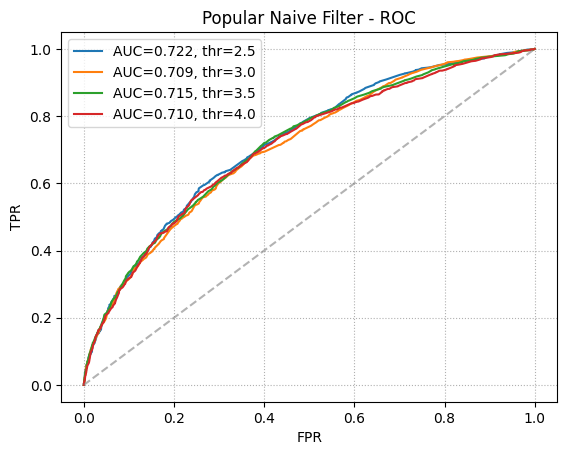

Unpopular - 10-fold CV - Avg RMSE: 0.8408


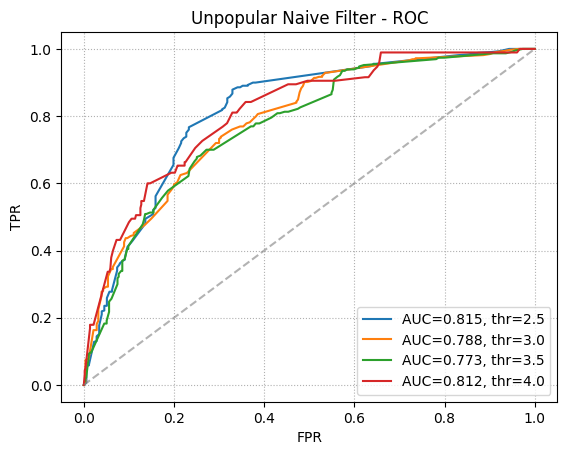

High-Variance - 10-fold CV - Avg RMSE: 0.7973


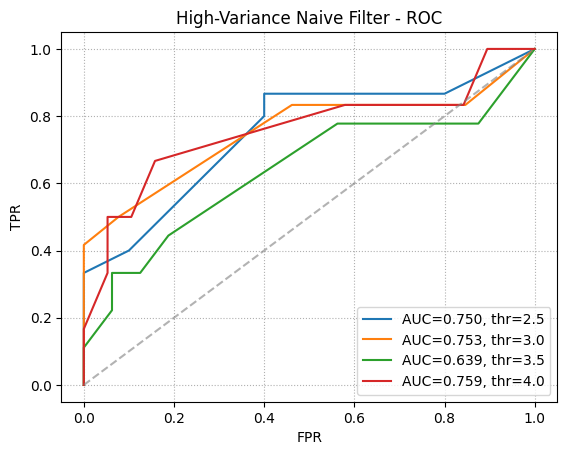

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, roc_curve, auc

def trim_data(raw_data, method='popular', rating_threshold=2, var_threshold=2.0, min_var_count=5):
    d={}
    for (u,i,r,t) in raw_data:
        if i not in d:
            d[i] = []
        d[i].append(r)
    if method=='popular':
        keep = {i for i in d if len(d[i])>rating_threshold}
    elif method=='unpopular':
        keep = {i for i in d if len(d[i])<=rating_threshold}
    elif method=='high_variance':
        keep = []
        for i in d:
            if len(d[i])>=min_var_count and np.var(d[i])>=var_threshold:
                keep.append(i)
        keep = set(keep)
    else:
        raise ValueError("Unknown trim method")
    return [(u,i,r,t) for (u,i,r,t) in raw_data if i in keep]

def compute_user_means(data_array):
    user_arr   = np.array([row[0] for row in data_array])
    rating_arr = np.array([row[2] for row in data_array])
    user_set   = np.unique(user_arr)
    user_mean_dict = {}
    for user_id in user_set:
        idx = np.where(user_arr == user_id)
        user_mean_dict[user_id] = np.mean(rating_arr[idx])
    return user_mean_dict

def naive_predict(user_means_dict, user_id):
    return user_means_dict.get(user_id, np.mean(list(user_means_dict.values())))

def naive_cv_and_roc(data_array, title):
    user_means_dict = compute_user_means(data_array)
    data_np = np.array(data_array, dtype=object)
    kf = KFold(n_splits=10, shuffle=True, random_state=0)
    rmses = []
    for train_idx, test_idx in kf.split(data_np):
        preds = []
        truth = []
        for row in data_np[test_idx]:
            uid = row[0]
            rating_true = row[2]
            rating_pred = naive_predict(user_means_dict, uid)
            preds.append(rating_pred)
            truth.append(rating_true)
        rmses.append(mean_squared_error(truth, preds, squared=False))
    mean_rmse = np.mean(rmses)
    print(f"{title} - 10-fold CV - Avg RMSE: {mean_rmse:.4f}")
    idxs = np.arange(len(data_np))
    train_idx, test_idx = train_test_split(idxs, test_size=0.1, random_state=0)
    train_array = data_np[train_idx]
    test_array  = data_np[test_idx]
    user_means_train = compute_user_means(train_array)
    preds_roc  = []
    truth_roc  = []
    for row in test_array:
        uid = row[0]
        truth_roc.append(row[2])
        preds_roc.append(naive_predict(user_means_train, uid))
    thresholds = [2.5,3.0,3.5,4.0]
    plt.figure()
    for thr in thresholds:
        y_true = [1 if r>thr else 0 for r in truth_roc]
        y_score = preds_roc
        fpr, tpr, _ = roc_curve(y_true, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"AUC={roc_auc:.3f}, thr={thr}")
    plt.plot([0,1],[0,1],'--',color='gray',alpha=0.6)
    plt.title(f"{title} Naive Filter - ROC")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend(loc='best')
    plt.grid(linestyle=':')
    plt.show()

ratings_data = ratings_dataset.raw_ratings
pop_data = trim_data(ratings_data,'popular',2)
unp_data = trim_data(ratings_data,'unpopular',2)
hv_data  = trim_data(ratings_data,'high_variance',2,2.0,5)

naive_cv_and_roc(ratings_data, "Full Data")
naive_cv_and_roc(pop_data, "Popular")
naive_cv_and_roc(unp_data, "Unpopular")
naive_cv_and_roc(hv_data,  "High-Variance")


# Question 12


### From the firgure below (please note that these ROCs are plotted at the optimal k's for each CF), we can see that SVD CF performs best among all the CF, followed by k-NN CF and NNMF-CF coming last. We explain the performance as follows:

### **SVD vs NMF**:

### SVD is able to better represent the higher-dimensional feature matrix due to no constraints on U and V, providing a deep factorization with low information loss. NMF on the other hand, restricts U and V to be positive and has fewer optimal choices of elements in U and V compared to SVD.

### SVD produces a hierarchical and geometric basis ordered by relevance, producing embeddings with the most relevant features and traits in the ratings matrix higher in the hierarchy. Thus, embeddingsproduced by SVD are robust to outliers and noise in the ratings thanks to the ordering of the features. NMF, on the other hand, does not consider the geometry in the ratings matrix.

### The embeddings produced by SVD are unique and deterministic, whereas NMF is non-unique and stochastic, with no guarantees of convergence to the optimal U and V each time the function is called.

### SVD takes into account user and movie-specific bias information and normalizes them appropriately to reduce sensitivity to outliers and noise.

### **Why SVD edges k-NN**:

### k-NN is not modeling the bias information separately for each user or item. As a result, it is more sensitive to outliers and rarely rated items.

### k-NN performs inference directly on the sparse ratings matrix, which yields poor prediction accuracy in high-dimensional space (curse of dimensionality). This also hurts the scalability of the recommender system. High-dimensional inference requires large amounts of training data to work properly, which is absent as the ratings matrix is sparse.

### k-NN is much less generalizable compared to latent-factor based models, as it cannot find semantic information and connections within the user-item ratings matrix while being sensitive to rarely rated items.

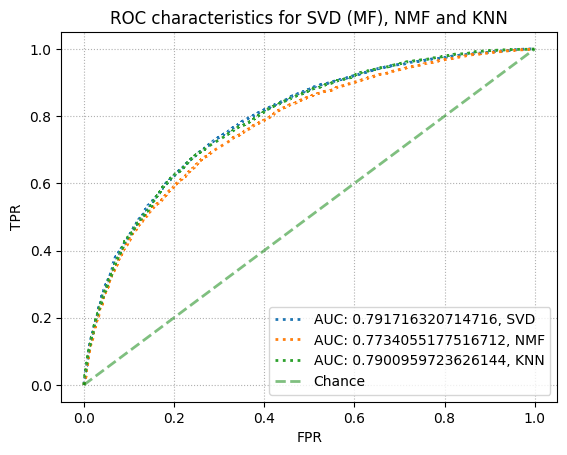

In [25]:
import matplotlib.pyplot as plt
from surprise import SVD, NMF, KNNWithMeans
from surprise import accuracy
from surprise.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Use Surprise's train_test_split, NOT sklearn's, on your Surprise dataset
trainset, testset = train_test_split(ratings_dataset, test_size=0.1, random_state=0)

# Fit each model on the Surprise 'trainset'
res_SVD  = SVD(n_factors=26, n_epochs=20, verbose=False).fit(trainset).test(testset)
res_NMF  = NMF(n_factors=18, n_epochs=50, verbose=False).fit(trainset).test(testset)
res_KNN  = KNNWithMeans(k=20, sim_options={'name':'pearson'}, verbose=False).fit(trainset).test(testset)

fig, ax = plt.subplots()

thresholded_out = []
for row in res_SVD:
    thresholded_out.append(1 if row.r_ui > 3 else 0)
fpr, tpr, _ = roc_curve(thresholded_out, [row.est for row in res_SVD])
ax.plot(fpr, tpr, lw=2, linestyle=':', label="AUC: "+str(auc(fpr,tpr))+", SVD")

thresholded_out = []
for row in res_NMF:
    thresholded_out.append(1 if row.r_ui > 3 else 0)
fpr, tpr, _ = roc_curve(thresholded_out, [row.est for row in res_NMF])
ax.plot(fpr, tpr, lw=2, linestyle=':', label="AUC: "+str(auc(fpr,tpr))+", NMF")

thresholded_out = []
for row in res_KNN:
    thresholded_out.append(1 if row.r_ui > 3 else 0)
fpr, tpr, _ = roc_curve(thresholded_out, [row.est for row in res_KNN])
ax.plot(fpr, tpr, lw=2, linestyle=':', label="AUC: "+str(auc(fpr,tpr))+", KNN")

ax.plot([0,1], [0,1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
ax.legend(loc='best')
ax.grid(linestyle=':')
ax.set_title('ROC characteristics for SVD (MF), NMF and KNN')
ax.set_xlabel('FPR')
ax.set_ylabel('TPR')
plt.show()
